<a href="https://www.kaggle.com/alexteboul/tutorial-part-2-model-building-using-the-metadata?scriptVersionId=89713829" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Tutorial Part 2: Model Building using the Metadata

Hello and welcome to Part 2 of this Pawpularity Contest Tutorial Series. In [Tutorial Part 1: EDA for Beginners ](https://www.kaggle.com/alexteboul/tutorial-part-1-eda-for-beginners/notebook), we covered the exploratory data analysis process from start to finish for the PetFinder.my Pawpularity Contest. If you'd like to learn more about how to explore and visualize both the metadata and image data for this competition, check out that notebook.

**To recap some important findings from that exploration:**
* The feature variables are all binary, 0s or 1s, while the target variable (Pawpularity) is 1-100.
* The feature variables appear to have similar distributions of pawpularity scores, between themselves and their respective classes (0s vs 1s).
* The images are hard to differentiate in terms of Pawpularity score just by looking at them.

In this notebook, I'm going to cover how to build some simple models using the metadata provided in the competition. By metadata, I'm referring to the .csv training data in this contest. According to the competition hosts, this data was created manually by people looking at the pet pictures and has features like Eyes, Group, Blur, Face, etc.

**In this notebook you'll learn about:**
* Decision Tree Classification
* Decision Tree Regression
* Ordinary Least Squares Regression
* Ridge Regression
* Bernoulli Naive Bayes Classification
* Random Forest Regression
* Histogram-based Gradient Boosting Regression (LightGBM)
* How to evaluate your models
* Plan for next steps

**TLDR:**
* All the models kind of suck and it's the metadata-Pawpularity relationship that is bad. Unlikely that any amount of parameter tuning or different models will make these too much better. Best bet is to use the images themselves. Which I will demonstrate in Tutorial Part 3.

| Model                                            | RMSE   |
|--------------------------------------------------|--------|
| 4.1 Decision Tree Regression                     | 20.857 |
| 4.2 Decision Tree Classification                 | 22.900 |
| 5.1 Ordinary Least Square Regression             | 20.827 |
| 5.2 Ridge Regression                             | 20.827 |
| 6.1 Bernoulli Naive Bayes Classification         | 23.468 |
| 7.1 Random Forest Regression                     | 20.838 |
| 7.2 Histogram-based Gradient Boosting Regression | 20.924 |

**Index:**
1. Load in your packages
2. Is this a Classification or Regression Problem?
3. Get the Data
4. Decision Trees  
 - 4.1 Decision Tree Regressor
 - 4.2 Decision Tree Classifier
5. Linear Models
 - 5.1 Ordinary Least Squares Regression
 - 5.2 Ridge Regression
6. Naive Bayes
 - 6.1 Bernoulli Naive Bayes 
7. Ensemble Methods
 - 7.1 Random Forest Regression
 - 7.2 Histogram-based Gradient Boosting Regression
8. Conclusion


**Tutorials so far:**

1. **In [Tutorial Part 1: EDA for Beginners](https://www.kaggle.com/alexteboul/tutorial-part-1-eda-for-beginners)**, we covered the exploratory data analysis process from start to finish for the PetFinder.my Pawpularity Contest.
2. **In [Tutorial Part 2: Model Building using the Metadata](https://www.kaggle.com/alexteboul/tutorial-part-2-model-building-using-the-metadata)**, we built models using the metadata (.csv data) provided by the competition hosts. Specifically, we tried Decision Tree Classification, Decision Tree Regression, Ordinary Least Squares Regression, Ridge Regression, Bernoulli Naive Bayes Classification, Random Forest Regression, and Histogram-based Gradient Boosting Regression (LightGBM). RMSE 20.54
3. **In [Tutorial Part 3: CNN Image Models 1](https://www.kaggle.com/alexteboul/tutorial-part-3-cnn-image-modeling-1)**, we explored preprocessing the training images, explaining the data types necessary to model with images, a basic Convolutional Neural Network architecture, and submitting predictions. 

-------

## 1: Load in your packages

In [1]:
#load in packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#Models
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


#use sklearn.metrics.mean_squared_error() AND math.sqrt() to get RMSE
from sklearn.metrics import mean_squared_error

#set a random_state to be used in the notebook
random_state = 7

------

## 2: Is this a Classification or Regression Problem?
One of the first questions to ask in the model building process is to determine what type of machine learning (ML) problem you are trying to solve. Because we are given example data with both Pawpularity scores and feature data in the metadata .csv files, we know that we can at least treat this as a supervised learning problem. We have labels --> okay cool it's supervised learning. 

Next, we need to decide whether this is a classication (categorical variable prediction) or regression (continous variable prediction). As it turns out, we can do either method in this case. We can treat the Pawpularity score as a continous variable for our regression models to predict, or as a categorical variable between 1-100 for our classification models to predict. 

When our predictions are judged however, the Root Mean Square Error (RMSE) metric will be used to evaluate model success. RMSE is the square root of the variance of the residuals (your prediction errors). More plainly, residuals are a measure of how far off from the regression line data points are. The RMSE is a metric that evaluates how spread apart these residuals actually are. Basically, the smaller the RMSE you get, the better. Theoretically, if your model perfectly predicted everything, RMSE would be 0. RMSE is typically associated with regression evaluation.

$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$

In [2]:
#Example of RMSE
example_y_actual    = [10,20,30,40,50,60,70,80,90,100]
example_y_predicted = [12,20,35,45,50,30,50,80,92,95]
example_MSE = mean_squared_error(example_y_actual, example_y_predicted)
example_RMSE = math.sqrt(example_MSE)
print("Example Mean Squared Error:", round(example_MSE,1))
print("Example Root Mean Square Error:", round(example_RMSE,1))

Example Mean Squared Error: 138.3
Example Root Mean Square Error: 11.8


-------

## 3: Get the data
First, load the data in from the train.csv so we can start training some models. We're going to be training and testing multiple models to get a sense of what works. It helps to start with this train/test splitting so that you can reuse the groups for each model.

Let's start with an 80-20 train-test split. So 80% of the train.csv will be used to train our models and 20% will be used to test how well the models work with new data. 

In [3]:
#load in the data:
#source path (where the Pawpularity contest data resides)
path = '../input/petfinder-pawpularity-score/'

#Get the metadata (the .csv data) and put it into DataFrames
train_df = pd.read_csv(path + 'train.csv')

#show the dimensions of the train metadata.
print('train_df dimensions: ', train_df.shape)
train_df.head(3)

train_df dimensions:  (9912, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28


We have our data in a dataframe, so let's store our feature variables in X and target variable in y. Note that Id has to be removed from the feature variables. We just want the columns our models can use.

In [4]:
#select Pawpularity as target variable:
y = train_df['Pawpularity']

#select all the other columns minus Id and Pawpualarirty as the feature variables:
X = train_df.drop(['Id','Pawpularity'],axis=1)

In [5]:
#now make the train-test splits
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)
print('Dimensions: \n x_train:{} \n x_test{} \n y_train{} \n y_test{}'.format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))

Dimensions: 
 x_train:(7929, 12) 
 x_test(1983, 12) 
 y_train(7929,) 
 y_test(1983,)


In [6]:
#x_train and x_test are dataframes
x_train.head(2)
#x_test.head(2)

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
1242,0,1,1,1,0,0,0,0,0,0,0,0
5219,0,1,1,1,0,0,0,0,0,0,0,0


In [7]:
#y_train and y_test are pandas series. .iloc[0:2] shows the first two elements of the series. In our case a pawpularity score of 26 and 11.
y_train.iloc[0:2]
#y_test.iloc[0]

1242    26
5219    11
Name: Pawpularity, dtype: int64

-------

## 4: Decision Trees
Decision trees are one of the most basic machine learning algorithms and on relatively small datasets they can be a good place to start. One interesting feature of decision trees is that they can be used for both regression and classification supervised learning problems. Check out this great decision trees explanation on KDNuggets: [Link](https://www.kdnuggets.com/2020/01/decision-tree-algorithm-explained.html)

### 4.1 Decision Tree Regressor
* Play around with the DecisionTreeRegressor parameters: [SciKit Documentation - Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

In [8]:
#create the Regressor
tree_reg = DecisionTreeRegressor(max_depth = 3, min_samples_split = 10)

#train the model
start = time.time()
tree_reg.fit(x_train, y_train)
stop = time.time()

#predict the response for the test data
tree_reg_pred = tree_reg.predict(x_test)

#print the RMSE
print(f'Training time: {round((stop - start),3)} seconds')
tree_reg_RMSE = math.sqrt(mean_squared_error(y_test, tree_reg_pred))
print(f'tree_reg_RMSE: {round(tree_reg_RMSE,3)}')

Training time: 0.008 seconds
tree_reg_RMSE: 20.857


Cool, we got a RMSE for our first model! Note that 20.857 is pretty bad, which suggests right off the bat that our initial assumptions about the models being unlikely to fit the data well were on track. 

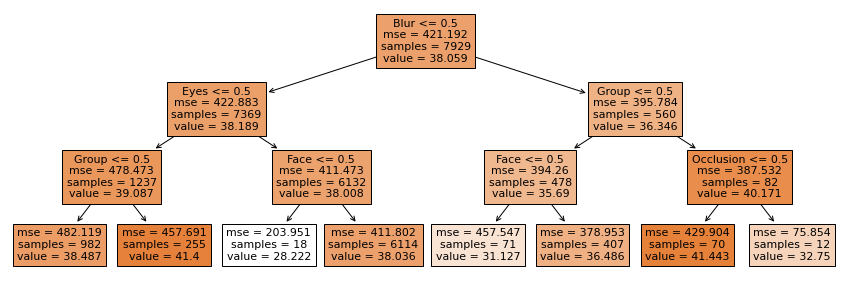

In [9]:
#visualize the decision tree
fig = plt.figure(figsize=(15,5))
plot = tree.plot_tree(tree_reg, feature_names=x_train.columns.values.tolist(), filled=True)

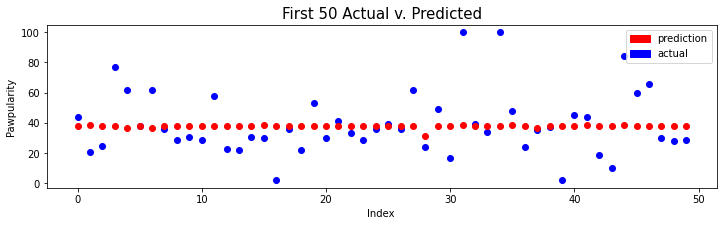

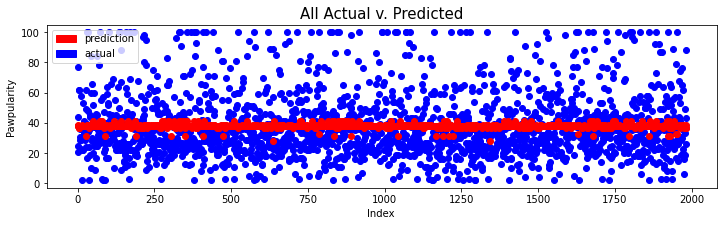

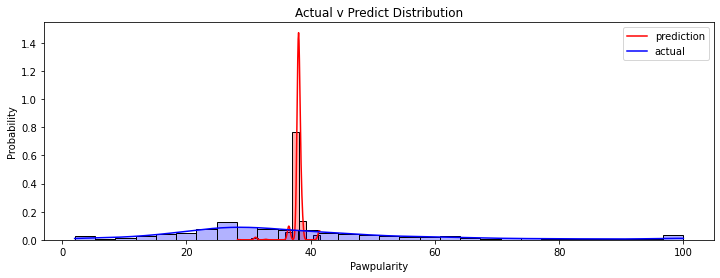

In [10]:
#let's see what our predictions look like vs the actual 
def ActualvPredictionsGraph(y_test,y_pred,title):
    if max(y_test) >= max(y_pred):
        my_range = int(max(y_test))
    else:
        my_range = int(max(y_pred))
    plt.figure(figsize=(12,3))
    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.xlabel('Index ')
    plt.ylabel('Pawpularity ')
    plt.title(title,fontdict = {'fontsize' : 15})
    plt.legend(handles = [mpatches.Patch(color='red', label='prediction'),mpatches.Patch(color='blue', label='actual')])
    plt.show()
    return

#plot it
ActualvPredictionsGraph(y_test[0:50], tree_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_test, tree_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(tree_reg_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

When you're actually submitting to the competition, you'd make the predictions on the test data from the competition. This is different from the test data we created to help with our model evaluation just now.

**How to submit to the competition:**
* #gets the data
    * test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
* #drops the Id column from the test_df dataframe (it already doesn't have Pawpularity so no need to remove that)
    * x_test_submission = test_df.drop(['Id'],axis=1)
* #predict with a model you've trained, in this case tree_reg, and add the predictions to the test_df dataframe
    * test_df['Pawpularity'] = tree_reg.predict(x_test_submission)
* #keep just the Id and Pawpularity score for the submission
    * submission_df = test_df[['Id','Pawpularity']]
* #save it to a .csv file called submission.csv
    * submission_df.to_csv("submission.csv", index=False)

In [11]:
#Now submit to the competition using the model:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv') #gets the data
x_test_submission = test_df.drop(['Id'],axis=1) #drops the Id column from the test_df dataframe (it already doesn't have Pawpularity so no need to remove that)
test_df['Pawpularity'] = tree_reg.predict(x_test_submission) #predict with a model you've trained, in this case tree_reg, and add the predictions to the test_df dataframe
submission_df = test_df[['Id','Pawpularity']] #keep just the Id and Pawpularity score for the submission
submission_df.to_csv("submission.csv", index=False) #save it to a .csv file called submission.csv
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,32.750000
1,43a2262d7738e3d420d453815151079e,28.222222
2,4e429cead1848a298432a0acad014c9d,32.750000
3,80bc3ccafcc51b66303c2c263aa38486,38.486762
4,8f49844c382931444e68dffbe20228f4,38.036474


### 4.2 Decision Tree Classifier
* Play around with the DecisionTreeClassifier parameters: [SciKit Documentation - Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [12]:
#create the Classifier
tree_clf = DecisionTreeClassifier(max_depth = 3, min_samples_split = 10)

#train the model
start = time.time()
tree_clf.fit(x_train, y_train)
stop = time.time()

#predict the response for the test data
tree_clf_pred = tree_clf.predict(x_test)

#print the RMSE
print(f'Training time: {round((stop - start),3)} seconds')
tree_clf_RMSE = math.sqrt(mean_squared_error(y_test, tree_clf_pred))
print(f'tree_clf_RMSE: {round(tree_clf_RMSE,3)}')

Training time: 0.009 seconds
tree_clf_RMSE: 22.9


Again pretty a pretty bad model, but just shows that you can use a decision tree for both classification and regression.

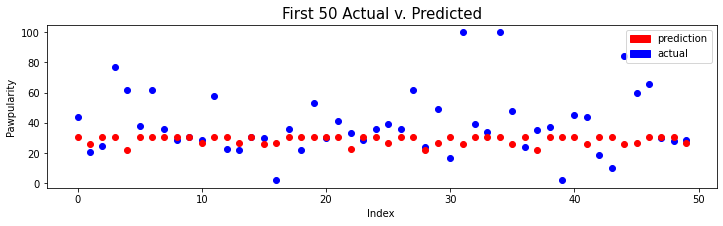

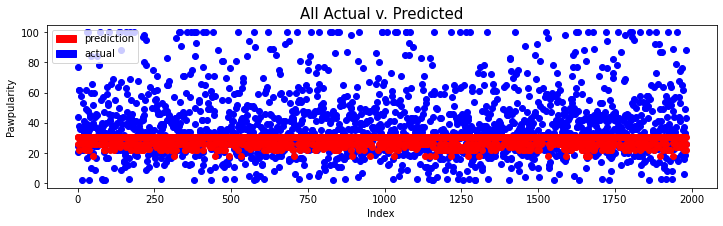

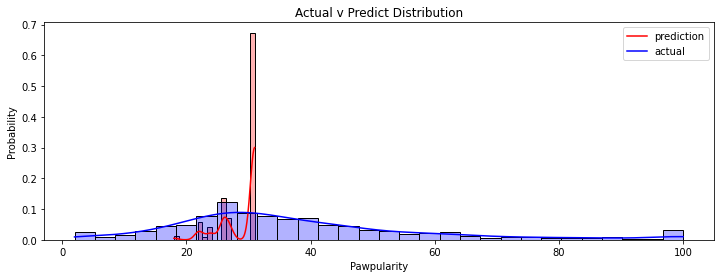

In [13]:
#plot it
ActualvPredictionsGraph(y_test[0:50], tree_clf_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_test, tree_clf_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(tree_clf_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

**Important:** Note that the classifier is really just predicting values are going to fall within a narrow range. It's doing a poor job of actually predicting based on how different pet features might be impacting the Pawpularity score. Instead, the model has learned that guessing near the mean Pawpularity scores is a good way to minimize the error. We do not want this!

In [14]:
#Now submit to the competition using the model:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
x_test_submission = test_df.drop(['Id'],axis=1) 
test_df['Pawpularity'] = tree_clf.predict(x_test_submission) 
submission_df = test_df[['Id','Pawpularity']]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,24
1,43a2262d7738e3d420d453815151079e,27
2,4e429cead1848a298432a0acad014c9d,18
3,80bc3ccafcc51b66303c2c263aa38486,26
4,8f49844c382931444e68dffbe20228f4,18


**Decision Trees Summary:** Decision Trees produced pretty poor models. But it's always good to know what doesn't work as well as what does.

* **tree_reg_RMSE:** 20.857
* **tree_clf_RMSE:** 22.900

--------

## 5: Linear Models
* Play around with the Linear Models and their parameters: [SciKit Documentation - Linear Models](https://scikit-learn.org/stable/modules/linear_model.html)

### 5.1 Ordinary Least Squares Regression
Most basic Linear Model is just linear regression. Multicollinearity problems, or the features being overly similar, have a big impact on these models. Feature selection is an important part of using linear models, but we're going to skip this for the sake of simplicity.
* Tune the OLS linear regression model and find more info: [SciKit Documentation - Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [15]:
#create the Ordinary Least Squares Regression model
ols_reg = LinearRegression()

#train the model
start = time.time()
ols_reg.fit(x_train, y_train)
stop = time.time()

#predict the response for the test data
ols_reg_pred = ols_reg.predict(x_test)

#print the RMSE
print(f'Training time: {round((stop - start),3)} seconds')
ols_reg_RMSE = math.sqrt(mean_squared_error(y_test, ols_reg_pred))
print(f'ols_reg_RMSE: {round(ols_reg_RMSE,3)}')

Training time: 0.008 seconds
ols_reg_RMSE: 20.827


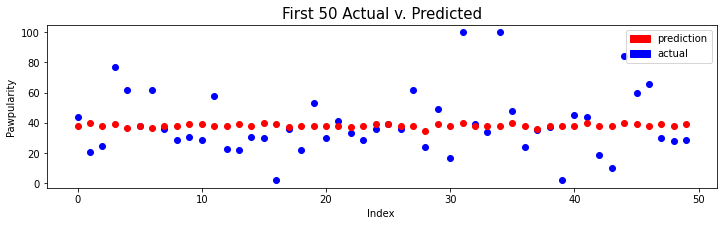

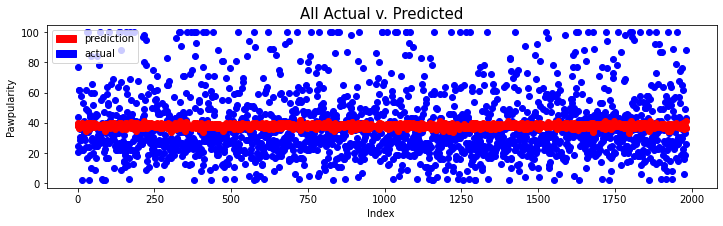

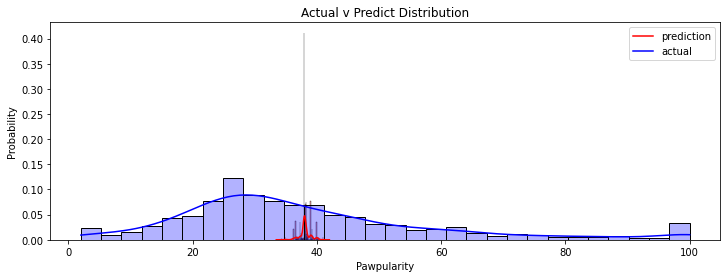

In [16]:
#plot it
ActualvPredictionsGraph(y_test[0:50], ols_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_test, ols_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(ols_reg_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

So the ordinary least squares linear regression model is even more narrow in its predictions than the decision trees - not great.

In [17]:
#Now submit to the competition using the model:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
x_test_submission = test_df.drop(['Id'],axis=1) 
test_df['Pawpularity'] = ols_reg.predict(x_test_submission) 
submission_df = test_df[['Id','Pawpularity']]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,36.246036
1,43a2262d7738e3d420d453815151079e,36.425192
2,4e429cead1848a298432a0acad014c9d,36.313064
3,80bc3ccafcc51b66303c2c263aa38486,36.918859
4,8f49844c382931444e68dffbe20228f4,35.003060


### 5.2 Ridge Regression
Another basic regression model is called ridge regression. Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares. Basically, the larger the value of alpha the greater the amount of shrinkage and thus the coefficients become more robust to collinearity. Let's see if this improves the model at all.
* For more on the documentation: [SciKit Learn Documentation - Ridge Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

In [18]:
#create the Ridge Regression model
ridge_reg = Ridge(alpha=2.0)

#train the model
start = time.time()
ridge_reg.fit(x_train, y_train)
stop = time.time()

#predict the response for the test data
ridge_reg_pred = ridge_reg.predict(x_test)

#print the RMSE
print(f'Training time: {round((stop - start),3)} seconds')
ridge_reg_RMSE = math.sqrt(mean_squared_error(y_test, ridge_reg_pred))
print(f'ridge_reg_RMSE: {round(ridge_reg_RMSE,3)}')

Training time: 0.007 seconds
ridge_reg_RMSE: 20.827


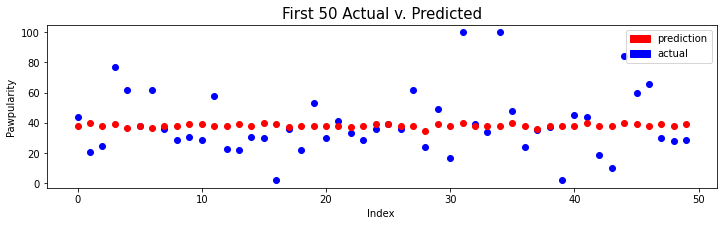

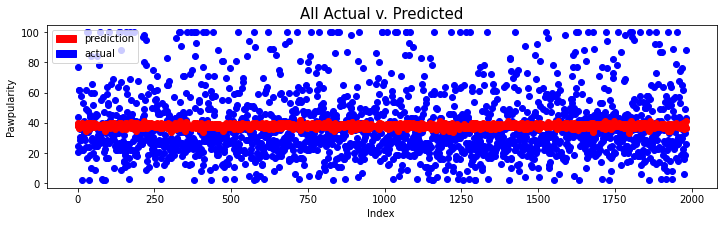

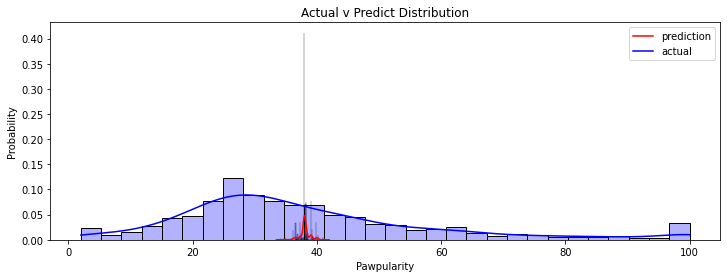

In [19]:
#plot it
ActualvPredictionsGraph(y_test[0:50], ridge_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_test, ridge_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(ridge_reg_pred,color='r',alpha=0.3,stat='probability', kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability',kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

Interesting, it's exactly the same as the OLS model. Think on why this is.

In [20]:
#Now submit to the competition using the model:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
x_test_submission = test_df.drop(['Id'],axis=1) 
test_df['Pawpularity'] = ridge_reg.predict(x_test_submission) 
submission_df = test_df[['Id','Pawpularity']]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,36.264858
1,43a2262d7738e3d420d453815151079e,36.443236
2,4e429cead1848a298432a0acad014c9d,36.335512
3,80bc3ccafcc51b66303c2c263aa38486,36.921253
4,8f49844c382931444e68dffbe20228f4,35.040376


Turns out the Ridge Regression is just as bad as the Ordinarly Least Squares Regression model. Let's try something that will better approximate and learn from the distribution of Pawpularity scores.

**Linear Models Summary:**
* **ols_reg_RMSE:** 20.827
* **ridge_reg_RMSE:** 20.827

------------

## 6: Naive Bayes
Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem. They have the “naive” assumption of conditional independence between every pair of features given the value of the target variable. They also tend to be reasonably fast.
* Learn more about Naive Bayes and play with the parameters: [SciKit Documentation - Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html)

### 6.1 Bernoulli Naive Bayes

BernoulliNB implements the naive Bayes algorithm for data that is distributed according to multivariate Bernoulli distributions. This means that each feature is assumed to be a binary-valued (Bernoulli, boolean) variable. This is the structure of the metadata we are given in this contest so let's see how this works. You'd typically see this used in some Natural Language Processing tasks, but it could be useful in this unique case as well.
* Learn more here: [SciKit Documentation - BernoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)

In [21]:
#create the Bernoulli Naive Bayes model
BernoulliNB_clf = BernoulliNB()

#train the model
start = time.time()
BernoulliNB_clf.fit(x_train, y_train)
stop = time.time()

#predict the response for the test data
BernoulliNB_clf_pred = BernoulliNB_clf.predict(x_test)

#print the RMSE
print(f'Training time: {round((stop - start),3)} seconds')
BernoulliNB_clf_RMSE = math.sqrt(mean_squared_error(y_test, BernoulliNB_clf_pred))
print(f'BernoulliNB_clf_RMSE: {round(BernoulliNB_clf_RMSE,3)}')

Training time: 0.035 seconds
BernoulliNB_clf_RMSE: 23.468


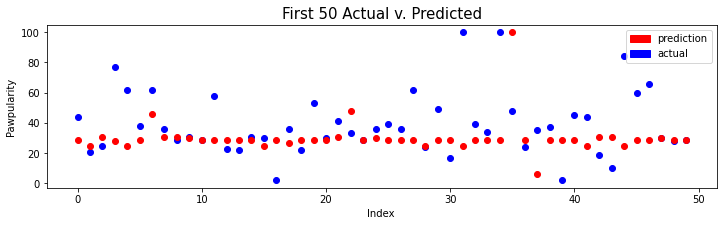

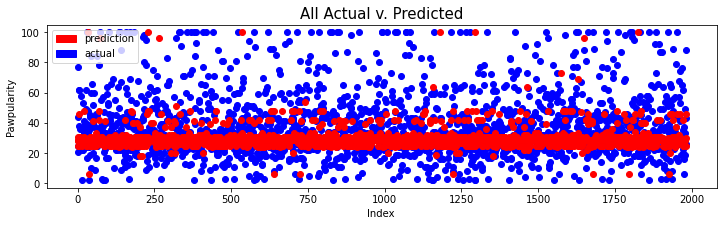

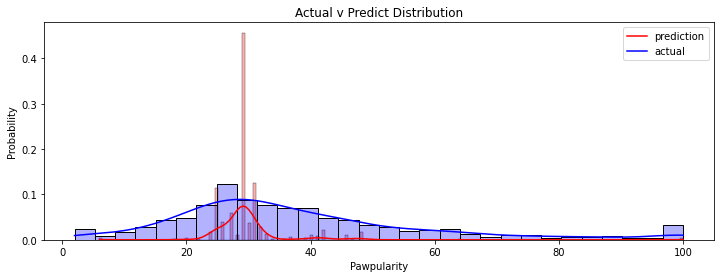

In [22]:
#plot it
ActualvPredictionsGraph(y_test[0:50], BernoulliNB_clf_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_test, BernoulliNB_clf_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(BernoulliNB_clf_pred,color='r',alpha=0.3,stat='probability',kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

In [23]:
#Now submit to the competition using the model:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
x_test_submission = test_df.drop(['Id'],axis=1) 
test_df['Pawpularity'] = BernoulliNB_clf.predict(x_test_submission) 
submission_df = test_df[['Id','Pawpularity']]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,90
1,43a2262d7738e3d420d453815151079e,27
2,4e429cead1848a298432a0acad014c9d,90
3,80bc3ccafcc51b66303c2c263aa38486,32
4,8f49844c382931444e68dffbe20228f4,95


So far this is actually the worst RMSE result, but notice how the predictions from this model more closely match the actual distribution of Pawpularity scores. So this model is not just guessing values close to the mean to get a good evaluation score, but actually predicting Pawpularity values that more closely resembles the true human interaction with these pet pictures. For this reason, I like this model the most so far, even though it has the worst RMSE so far.

**Naive Bayes Summary:**
* **BernoulliNB_clf_RMSE:** 23.468

-------

## 7: Ensemble Methods
Ensemble methods can be quite useful in a number of applications. If you want to learn more about ensemble methods, bagging, boosting, and stacking, check out this great resource online: [Link](https://analyticsindiamag.com/basics-of-ensemble-learning-in-classification-techniques-explained/). Some of them like Random Forests can get quite slow to train on big datasets, but we this is a small enough dataset for them. For now, I'll just show Random Forests and a version of Gradient Boosting called Histogram-based Gradient Boosting Classification Tree based on LightGBM.

* If you want to learn more about Ensemble Methods or try out different ones: [SciKit Learn Documentation - Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html#ensemble)

### 7.1 Random Forest
The random forest ensemble is pretty much just making a bunch of decision trees and coming to consesus about how to get a single prediction from the many trees.
* For more on the Random Forest and parameter tuning: [SciKit Learn Documentation - Random Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [24]:
#create the Random Forest ensemble
RF_reg = RandomForestRegressor(n_estimators=50, max_depth=3)

#train the model
start = time.time()
RF_reg.fit(x_train, y_train)
stop = time.time()

#predict the response for the test data
RF_reg_pred = RF_reg.predict(x_test)

#print the RMSE
print(f'Training time: {round((stop - start),3)} seconds')
RF_reg_RMSE = math.sqrt(mean_squared_error(y_test, RF_reg_pred))
print(f'RF_reg_RMSE: {round(RF_reg_RMSE,3)}')

Training time: 0.16 seconds
RF_reg_RMSE: 20.826


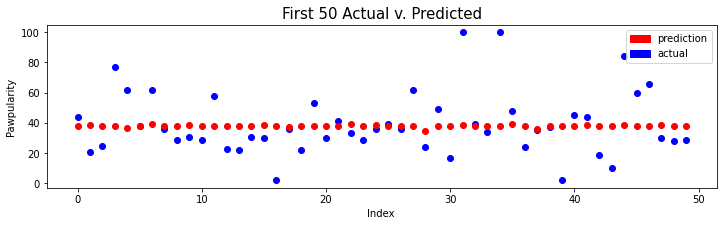

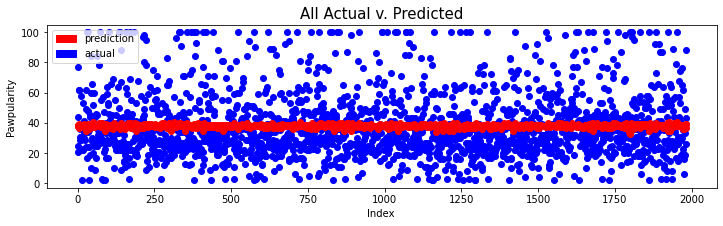

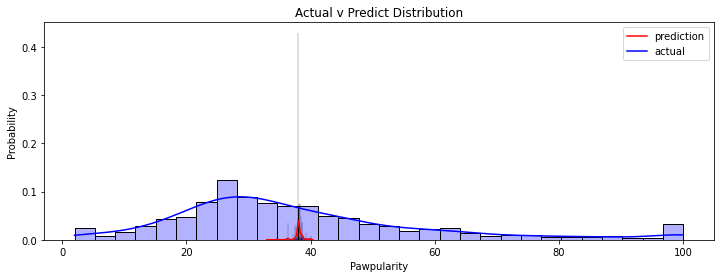

In [25]:
#plot it
ActualvPredictionsGraph(y_test[0:50], RF_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_test, RF_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(RF_reg_pred,color='r',alpha=0.3,stat='probability',kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

In [26]:
#Now submit to the competition using the model:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
x_test_submission = test_df.drop(['Id'],axis=1) 
test_df['Pawpularity'] = RF_reg.predict(x_test_submission) 
submission_df = test_df[['Id','Pawpularity']]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,36.931987
1,43a2262d7738e3d420d453815151079e,37.085343
2,4e429cead1848a298432a0acad014c9d,36.217300
3,80bc3ccafcc51b66303c2c263aa38486,36.329671
4,8f49844c382931444e68dffbe20228f4,33.864972


The Random Forest isn't really any better than a simple decision tree in our case.  It predicts in pretty much the same way by guessing everything has Pawpularity near the mean Pawpularity score.

### 7.2 Histogram-based Gradient Boosting Regression
This is pretty much **LightGBM** but you can use it in scikit learn! Because it's experimental, you have to call: from sklearn.experimental import enable_hist_gradient_boosting as well.
* For more and parameter info: [SciKit Learn Documentation - Histogram-based Gradient Boosting Regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)


In [27]:
#create the Histogram-based Gradient Boosting Regression model
HistGB_reg = HistGradientBoostingRegressor()

#train the model
start = time.time()
HistGB_reg.fit(x_train, y_train)
stop = time.time()

#predict the response for the test data
HistGB_reg_pred = HistGB_reg.predict(x_test)

#print the RMSE
print(f'Training time: {round((stop - start),3)} seconds')
HistGB_reg_RMSE = math.sqrt(mean_squared_error(y_test, HistGB_reg_pred))
print(f'HistGB_clf_RMSE: {round(HistGB_reg_RMSE,3)}')

Training time: 0.976 seconds
HistGB_clf_RMSE: 20.924


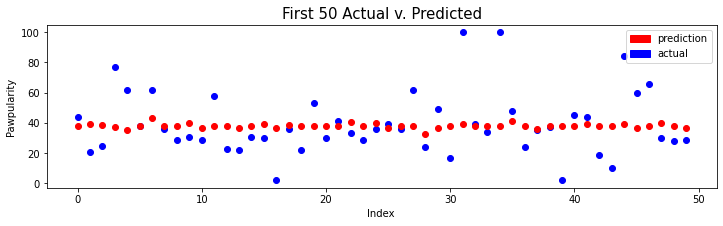

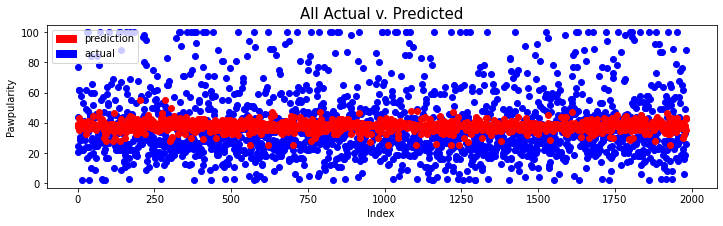

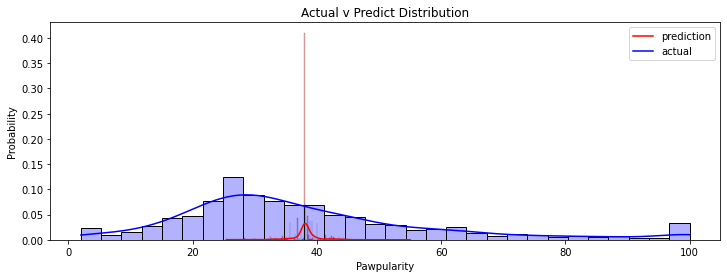

In [28]:
#plot it
ActualvPredictionsGraph(y_test[0:50], HistGB_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(y_test, HistGB_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(HistGB_reg_pred,color='r',alpha=0.3,stat='probability',kde=True)
sns.histplot(y_test,color='b',alpha=0.3,stat='probability', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

In [29]:
#Now submit to the competition using the model:
test_df = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
x_test_submission = test_df.drop(['Id'],axis=1) 
test_df['Pawpularity'] = HistGB_reg.predict(x_test_submission) 
submission_df = test_df[['Id','Pawpularity']]
submission_df.to_csv("submission.csv", index=False)
submission_df.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,39.066105
1,43a2262d7738e3d420d453815151079e,39.899667
2,4e429cead1848a298432a0acad014c9d,38.080445
3,80bc3ccafcc51b66303c2c263aa38486,33.120617
4,8f49844c382931444e68dffbe20228f4,26.281006


Nice, so our ensemble methods worked, but not significantly better than simpler models. Also because this HistGB model is the last one in the doc that's what would be submitted, but better to have a separate notebook with only 1 model your actual submissions.

**Ensemble Methods Summary:**
* **RF_reg_RMSE:** 20.838
* **HistGB_clf_RMSE:** 20.924

-------

## 8: Conclusion

We ran 7 different models, and none did particularly well! 😅

**Summary of Models:**

| Model                                            | RMSE   |
|--------------------------------------------------|--------|
| 4.1 Decision Tree Regression                     | 20.857 |
| 4.2 Decision Tree Classification                 | 22.900 |
| 5.1 Ordinary Least Square Regression             | 20.827 |
| 5.2 Ridge Regression                             | 20.827 |
| 6.1 Bernoulli Naive Bayes Classification         | 23.468 |
| 7.1 Random Forest Regression                     | 20.838 |
| 7.2 Histogram-based Gradient Boosting Regression | 20.924 |


These appear to suck because the metadata is just not really predictive of the target Pawpularity. The fact that all the models score pretty similarly even when parameters are modified supports this idea. All the models are pretty much just guessing the mean or close to it in an attempt to minimize errors. You could probably sit here all day trying to find the perfect parameter settings for these or other models, but it will never produce incredible results. In this case, the data and the target are the problem - not the models chosen. From this we can conclude that if there is in fact a way to build better models for pawpularity, it will involve using the images and not this metadata. 

I'll post a Tutorial Part 3 soon which will cover how to build models using the images and hopefully see some lower RMSE scores!

### Hope this helped!